In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

TENSORFLOW = False

if TENSORFLOW:
    # TensorFlow ≥2.0 is required
    import tensorflow as tf
    assert tf.__version__ >= "2.0"

    if not tf.config.list_physical_devices('GPU'):
        print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
        
else:
    # Torch ≥1.4.0 is required
    import torch 
    assert torch.__version__ >= "1.4.0"

    if torch.cuda.is_available():
        print('GPU support (%s)' % torch.cuda.get_device_name(0))
    else:
        print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

GPU support (GeForce RTX 2080)
cuda:0


In [2]:
import os
import sys
import copy
from datetime import datetime
from pathlib import Path
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import argmax
import pandas as pd

if TENSORFLOW:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.python.keras import backend as K # beware of .python. here
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (BatchNormalization, Conv1D, Conv2D, Dense, 
                                         Flatten, Input, TimeDistributed, Activation, 
                                         Bidirectional, SimpleRNN, GRU, LSTM, Reshape)
    from tensorflow.keras.layers import Lambda
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
else:
    import torch.nn as nn
    import torch.optim as optim

In [3]:
!pip -q install watermark
import watermark
%load_ext watermark
%watermark --iversions

matplotlib 3.0.3
pandas     0.25.1
numpy      1.17.4
seaborn    0.9.0
torch      1.4.0
watermark  1.8.1



In [4]:
df = pd.read_csv('fr_wiktionary_full.csv', sep='\t')
#df = pd.read_csv('fr_wiktionary_waves_r.csv', sep='\t')
#df = pd.read_csv('fr_wiktionary_waves.csv', sep='\t')
df = df.dropna()
df = df[df.Audio != '-']
df[df.Mot.str.startswith('a')].head()

,Mot,Prononciation,H_aspiré,Type,Audio,Pré_valide,Warn_code,Warn_label
39093,a,a,False,pronom personnel,[],True,-,-
39094,a,a,False,lettre,[],True,-,-
39095,a,ɑ,False,lettre,[],True,-,-
39096,a,a,False,verbe_flexion,[],True,-,-
39097,a beau mentir qui vient de loin,a bo mɑ̃.tiʁ ki vjɛ̃ də lwɛ̃,False,locution-phrase,[],False,err_too_many_spaces,6_spaces


In [5]:
PHONEMES = [
        # Voyelles
        'i','e','ɛ','a','ɑ','ɔ','o','u','y','ø','œ','ə','ɛ̃','ɑ̃','ɔ̃','œ̃',
        # Semi-consonnes
        'j','w','ɥ', 
        # Consonnes
        'p','t','k','b','d','ɡ','f','s','ʃ','v','z','ʒ','l','ʁ','m','n','ɲ','ŋ',
    ]
    
def print_phonemes():
    i = 0 
    for i in range(len(PHONEMES) + 2):
        if i == 0:
            print("' 0")
        elif i == 1:
            print('<SPACE> 1')
        else:
            print('%s %d' % (PHONEMES[i-2], i))

In [6]:
# Skip samples whose pronunciation contains unknown phonemes
df = df[~df['Prononciation'].isin(PHONEMES)]

In [7]:
df.shape

(1503368, 8)

In [8]:
df.Prononciation.str.len().max()

120

In [9]:
df[df.Mot=='tonton']

,Mot,Prononciation,H_aspiré,Type,Audio,Pré_valide,Warn_code,Warn_label
1391761,tonton,tɔ̃.tɔ̃,False,nom,[],True,-,-


In [10]:
char_map_str = """
' 0
<SPACE> 1
i 2
e 3
ɛ 4
a 5
ɑ 6
ɔ 7
o 8
u 9
y 10
ø 11
œ 12
ə 13
ɛ̃ 14
ɑ̃ 15
ɔ̃ 16
œ̃ 17
j 18
w 19
ɥ 20
p 21
t 22
k 23
b 24
d 25
ɡ 26
f 27
s 28
ʃ 29
v 30
z 31
ʒ 32
l 33
ʁ 34
m 35
n 36
ɲ 37
ŋ 38
"""

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

In [11]:
def get_phonemes(pronunciation):
    
    phonemes = []
    for i in range(len(pronunciation)):
        if i < len(pronunciation) - 1:
            if pronunciation[i]=='̃':
                continue
            if pronunciation[i+1]=='̃':
                if pronunciation[i] == 'ɑ':
                    phoneme = 'ɑ̃'
                elif pronunciation[i] == 'ɔ':
                    phoneme = 'ɔ̃'
                elif pronunciation[i] == 'œ':
                    phoneme = 'œ̃'
                elif pronunciation[i] == 'ɛ':
                    phoneme = 'ɛ̃'
                else:
                    print('can not happen c=%s' % c)
            else:
                phoneme = pronunciation[i]
        else:
            if pronunciation[i]=='̃':
                continue
            else: 
                phoneme = pronunciation[i]
        phonemes.append(phoneme)
    return phonemes

def get_padded_phonemes(pronunciation, str_len_max):
    
    padded_phonemes = get_phonemes(pronunciation)    
    # pad list of phonemes
    for i in range(len(padded_phonemes), str_len_max):
        padded_phonemes.append("'")
    return padded_phonemes

def get_tk_padded_phonemes(pronunciation, str_len_max):
    
    padded_phonemes = get_padded_phonemes(pronunciation, str_len_max)
    tk_padded_phonemes = []
    # tokenize each phoneme
    for phoneme in padded_phonemes:
        tk_padded_phonemes.append(char_map[phoneme])
    
    nb = len(padded_phonemes)
    np_array = np.array(tk_padded_phonemes).reshape(1, nb)
    
    return np_array
    
assert get_phonemes('tɛ̃bʁ') == ['t', 'ɛ̃', 'b', 'ʁ']
assert get_phonemes('tɔ̃tɔ̃') == ['t', 'ɔ̃', 't', 'ɔ̃']
assert get_padded_phonemes('tɛ̃bʁ', 6) == ['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]
assert np.array_equal(get_tk_padded_phonemes('tɛ̃bʁ', 6), np.array([[22, 14, 24, 34,  0,  0]]))

def get_prononciation(padded_phonemes):
    
    prononciation = ''
    for padded_phoneme in padded_phonemes:
        if padded_phoneme == "'":
            break
        else:
            prononciation += padded_phoneme

    return prononciation
assert get_prononciation(['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]) == 'tɛ̃bʁ', 6

In [12]:
def get_string_to_numpy(string, nb_max_chars):
    
    if nb_max_chars < len(string):
        raise ValueError('must not happen: nb_max_chars:%d too smal for string:%s (%d letters)'
             % (nb_max_chars, string, len(string)))
        return ''
    
    np_string = np.zeros((nb_max_chars))
    for i in range(len(string)):
        np_string[i] = ord(string[i])
        
    return np_string

def get_string_from_numpy(np_string):
    
    string=''
    for i in range(np_string.shape[0]):
        code = int(np_string[i])
        if code == 0:
            break
        else:
            string += chr(code)
    return string


assert get_string_from_numpy(get_string_to_numpy("tɛ̃bʁ", 6)) == "tɛ̃bʁ"

In [13]:
def get_audio_files_names(audio_files_str, speakers=[], verbose=False):
    if verbose:
        print('audio_files=*%s*' % audio_files_str)
    if audio_files_str == '[]':
        if verbose:
            print('empty list')
        audio_file_names = []
    else:
        if audio_files_str.startswith('['):
            files_string = audio_files_str[2:-2]
        else:
            files_string = audio_files_str
        files_string += '\', \''
        audio_file_names = files_string.split('\', \'')
        audio_file_names = audio_file_names[:-1]
        audio_file_names2 = []
        for audio_file_name in audio_file_names:
            if len(speakers) == 0:
                audio_file_names2.append(audio_file_name)
            else:
                for speaker in speakers:         
                    if speaker in audio_file_name:
                        audio_file_names2.append(audio_file_name)
        audio_file_names = audio_file_names2        
        if verbose:
            for f in audio_file_names:
                print('file=%s' % f)
    return audio_file_names

assert get_audio_files_names("[]") == []
assert get_audio_files_names("['a.wav']") == ['a.wav']
assert get_audio_files_names("LL-Q150 (fra)-LoquaxFR-&amp;.wav") == ['LL-Q150 (fra)-LoquaxFR-&amp;.wav']
assert get_audio_files_names("['a.wav', 'b.wav', 'c.wav']") == ['a.wav', 'b.wav', 'c.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['foo']) == ['-foo-a.wav', '-foo-d.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['bar']) == ['-bar-b.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['bar', 'foo']) == ['-foo-a.wav', '-bar-b.wav', '-foo-d.wav']

In [14]:
allowed_IPA_letters = [
            'a', 'b', 'd', 'e', 'f', 'i', 'j', 'k', 'l', 
            'm', 'n', 'o','p', 's', 't', 'u', 'v', 'w', 'y', 
            'z', 'ø', 'ŋ', 'œ', 'ɑ', 'ɔ', 'ə', 'ɛ', 'ɡ', 'ɥ',
            'ɲ', 'ʁ', 'ʃ', 'ʒ', '̃'   
]

''' Retrieve the dataset 
'''
def get_data(mfcc_dir, n_max=sys.maxsize, n_max_phonemes=sys.maxsize, 
             speakers=[], verbose=False, order=False, check_phonemes=True):    
    
    df = pd.read_csv('fr_wiktionary_waves.csv', sep='\t')
    df = df[df.Audio != '-']

    df = df[df.Prononciation.str.len() <= n_max_phonemes]
    print('df.shape:%d (with len(prononciation)<=%d)' % (df.shape[0], n_max_phonemes))
    
    # filter out samples from selected speakers, if any
    df0 = pd.DataFrame(columns=df.columns)
    if len(speakers) > 0:
        for speaker in speakers:
            df0 = pd.concat([df0, df[df['Audio'].str.contains(speaker)]])
        df = df0
    
    # reindex the dataframe by the Pronunciation column lenght
    if order:
        s = df.Prononciation.str.len().sort_values(ascending=True).index
        df = df.reindex(s)
    else:
        # reshuffle the index
        df = df.sample(frac=1).reset_index(drop=True)
    
    # clean pronunciation
    # rows having a pronnuciation with "bad" caracter will be dropped from the df
    if check_phonemes:
        indexes_to_drop = []
        bad_letters = {}   
        for index, row in df.iterrows():
            prononciation = row['Prononciation']
            prononciation = prononciation.replace('(','').replace(')','').replace('‿','').\
            replace('.','').replace(' ','').replace('͡','').replace('-','').replace('ˈ','').\
            replace('ː','').replace('r', 'ʁ')
            #prononciation = merge_nasals(prononciation)
            for phoneme in prononciation:            
                if phoneme not in allowed_IPA_letters:
                    if phoneme not in bad_letters.keys():
                        bad_letters[phoneme] = 0
                    bad_letters[phoneme] += 1
                    if verbose:
                        print('bad phoneme %s in [%s] /%s/' % (phoneme, row['Mot'], row['Prononciation']))
                    indexes_to_drop.append(index)
                    break
            df.at[index, 'Prononciation'] = prononciation            
        print('bad_letters=', bad_letters)
        df = df.drop(indexes_to_drop)
    
    # read 1 mfcc file to learn the maximum shape of the samples in the directory
    mfcc_shape_t = 0 #87
    mfcc_shape_d = 0 #40
    
    for index, row in df[df.Audio != '-'].iterrows():
       
        mfcc_file = ''
        wav_files = get_audio_files_names(row['Audio'])
        if verbose:
            print('Audio=*%s*' % row['Audio'])
        for wav_file in wav_files:
            if verbose:
                print('wav_file=*%s*' % wav_file)
            mfcc_file = wav_file.replace('.wav','.npy').replace(' ','_') 
            mfcc_filename = mfcc_dir + mfcc_file
            
            if os.path.exists(mfcc_filename):
                mfcc = np.load(mfcc_filename)
                mfcc_shape_t = max(mfcc_shape_t, mfcc.shape[1])
                mfcc_shape_d = mfcc.shape[0]
                break
            else:
                if verbose:
                    print('mfcc_file=*%s* not found !!!' % mfcc_file)
    if mfcc_shape_t == 0:
        print('mfcc_shape_t not found !!!' % mfcc_file)
        return 0
    
    # mfcc_shape_t=87 # if time==2.0
    # mfcc_shape_d=40 #
    print('mfcc_shape_t:%d', mfcc_shape_t)
    print('mfcc_shape_d:%d', mfcc_shape_d)
    
    n_max = df.shape[0]
    n_ok=0
    n_ko=0
    
    # numpy shapes to be ready to be used as inputs and targets
    mfccs = np.zeros((n_max, mfcc_shape_t, mfcc_shape_d))
    phonemess = np.zeros((n_max, n_max_phonemes))
    CHAR_MAX = 50
    motss = np.zeros((n_max, CHAR_MAX))
    prononciationss = np.zeros((n_max, CHAR_MAX))
    #mots = []
    #prononciations = []
    
    for index, row in df.sample(n_max).iterrows(): # sample() is used to shuffle data           
    #for index, row in df.iterrows(): # sample() is used to shuffle data           
        
        mfcc_file = ''
        wav_files = get_audio_files_names(row['Audio'], speakers=speakers)
        # so far, take only first file (to be enhanced!!!)
        mfcc_file = wav_files[0].replace('.wav','.npy').replace(' ','_')
        
        if mfcc_file == '':
            continue
        
        mfcc_filename = mfcc_dir + mfcc_file
        if os.path.exists(mfcc_filename):
            mfcc = np.load(mfcc_filename)
            if verbose:            
                print('mfcc.shape:', mfcc.shape)
            
            if mfcc[-1][-1] != 0.0:
                try:
                    if verbose:
                        print('pb for %s' % row['Mot'])
                except:
                    print('#')
                continue
            
            # add the mfcc in the mfccs table
            mfccs[n_ok,:,:] = mfcc.transpose()[:,:]
        
            # fetch the prononciation
            mot = row['Mot']
            prononciation = row['Prononciation']
            prononciation = prononciation.replace('(','').replace(')','').replace('‿','').\
            replace('.','').replace(' ','').replace('͡','').replace('-','').replace('ˈ','').\
            replace('ː','').replace('r', 'ʁ')
            
            phonemes = get_tk_padded_phonemes(prononciation, n_max_phonemes)
            
            # add the mfcc in the mfccs table
            phonemess[n_ok,:] = phonemes
            #mots.append(mot)
            #prononciations.append(prononciation)
            try :
                motss[n_ok:] = get_string_to_numpy(mot, CHAR_MAX)
                prononciationss[n_ok:] = get_string_to_numpy(prononciation, CHAR_MAX)
                n_ok += 1
                if n_ok > n_max - 1:
                    break
            except:
                print("error for mot=%s, mot or pronuciation is float!!!!!!!!!!!!!!!!!" % mot)
                n_ko += 1
        else:
            if verbose:
                print('file ko:', mfcc_file)
            n_ko += 1
            
    print('n_ok:',n_ok)
    print('n_ko:',n_ko)
    
    # delete unused rows
    mfccs = mfccs[:n_ok,:,:]
    phonemess = phonemess[:n_ok]
    prononciationss = prononciationss[:n_ok]
    motss = motss[:n_ok]
    
    print('mfccs.shape:', mfccs.shape)
    print('phonemess.shape:', phonemess.shape)
    print('prononciationss.shape:', prononciationss.shape)
    print('motss.shape:', motss.shape)
    #print('len(prononciations):', len(prononciations))
    #print('len(mots):', len(mots))
        
    return n_ok, mfccs, phonemess, prononciationss, motss

In [15]:
AUDIO_DIR = 'audio/'
TIME_MAX = 2.0
MFCC_FREQS = 40
#MFCC_FREQS = 90
MFCC_DIR = 'mfcc_' + str(TIME_MAX) + '_' + str(MFCC_FREQS) + '/'

TARGET_PHONEMES_MAX = 20
ORDER = False

NB_TEST_SAMPLES = 1000
print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

#speakers = ['WikiLucas'] # 19545 mots => 90: n_tested:100, n_ok:60, n_ko:40
#speakers = ['Lepticed'] #6145 => n_tested:100, n_ok:51, n_ko:49
speakers = ['WikiLucas', 'Lepticed'] # 25690
#speakers = ['Lyokoï'] # 9039 mots => n_tested:100, n_ok:62, n_ko:38
speakers = ['WikiLucas', 'Lepticed','Lyokoï'] # 90 : n_ok:64, n_ko:36 , 40: n_ok:66, n_ko:34
#speakers = [] # 30000 mots => 40:n_ok:61, n_ko:39

print('TARGET_PHONEMES_MAX:', TARGET_PHONEMES_MAX)
print('ORDER:', ORDER)

t0 = datetime.now()
n, mfccs, phonemes, prononciations, mots = get_data(mfcc_dir = MFCC_DIR, 
                                                    n_max=30000,
                                                    n_max_phonemes=TARGET_PHONEMES_MAX,
                                                    speakers = speakers, 
                                                    order=ORDER)
t1 = datetime.now()
data_import_duration = t1 - t0
print('data_import_duration', data_import_duration)

NB_TEST_SAMPLES:1000
TARGET_PHONEMES_MAX: 20
ORDER: False
df.shape:58761 (with len(prononciation)<=20)
bad_letters= {'·': 7, 'ʀ': 1, 'ʔ': 6, 'ʰ': 1, 'ᵊ': 2, 'ɒ': 1, '̥': 3, '…': 3, '̩': 1, 'ʌ': 1, 'h': 12, 'ɪ': 5, 'ʊ': 1, '̯': 2, 'ε': 2, ',': 2, 'x': 1, '/': 1, 'ˌ': 1}
mfcc_shape_t:%d 87
mfcc_shape_d:%d 40
n_ok: 34729
n_ko: 54
mfccs.shape: (34729, 87, 40)
phonemess.shape: (34729, 20)
prononciationss.shape: (34729, 50)
motss.shape: (34729, 50)
data_import_duration 0:00:50.515618


In [16]:
phonemes.shape

(34729, 20)

In [17]:
mfccs.shape

(34729, 87, 40)

In [18]:
type(mfccs[0,0,0])

numpy.float64

In [19]:
n_wished_test = NB_TEST_SAMPLES
n_wished_train = n - n_wished_test
n_train_ratio = int(n_wished_train/n_wished_test)
print('n_train_ratio:%d',n_train_ratio)

# following code is somehow complex "just" to have the option to 
# preserve increased-length order in both the training and
# tests data.

# delete 1 row every n_train_ratio rows
mfccs_train = np.delete(mfccs, list(range(0, mfccs.shape[0], n_train_ratio)), axis=0)
phonemes_train = np.delete(phonemes, list(range(0, phonemes.shape[0], n_train_ratio)), axis=0)
prononciations_train = np.delete(prononciations, list(range(0, phonemes.shape[0], n_train_ratio)), axis=0)
mots_train = np.delete(mots, list(range(0, mots.shape[0], n_train_ratio)), axis=0)
X_train = mfccs_train
Y_train = phonemes_train

# keep 1 row every n_train_ratio
mfccs_test = mfccs[0::n_train_ratio]
phonemes_test = phonemes[0::n_train_ratio]
prononciations_test= prononciations[0::n_train_ratio]
mots_test = mots[0::n_train_ratio]
X_test = mfccs_test
Y_test = phonemes_test

n_train_ratio:%d 33


In [20]:
# get ride of few samples in order to respect the number of
# wanted test samples (e.g. decimal "round" number like 100)
# which will allow for direct estimation of percentages.
if mfccs_test.shape[0] - NB_TEST_SAMPLES > 0:
    mfccs_test = mfccs_test[0:NB_TEST_SAMPLES]
    phonemes_test = phonemes_test[0:NB_TEST_SAMPLES]
    mots_test = mots_test[0:NB_TEST_SAMPLES]
    X_test = mfccs_test
    Y_test = phonemes_test
NB_TRAINING_SAMPLES = X_train.shape[0]
print('NB_TRAINING_SAMPLES:%d' % NB_TRAINING_SAMPLES)
print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

NB_TRAINING_SAMPLES:33676
NB_TEST_SAMPLES:1000


In [21]:
x_train_mean = X_train.mean()
x_train_std = X_train.std()
X_train -= x_train_mean
X_train /= x_train_std

In [22]:
X_test -= x_train_mean
X_test /= x_train_std

In [23]:
# Define the model
class CNN(nn.Module):
  def __init__(self, D, max_string_len, C, T):
    super(CNN, self).__init__()
    #self.V = n_vocab
    self.D = D
    self.K = C
    self.max_string_len = max_string_len
    self.T = T
    self.first_time = True

    
    #torch.nn.Conv1d(in_channels, out_channels, kernel_size, 
    #                stride=1, padding=0, dilation=1, groups=1, 
    #                bias=True, padding_mode='zeros')
    self.conv1 = nn.Conv1d(self.D, 128, 3, stride=1, padding=1) 
    #self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(128, 256, 3, stride=1, padding=1)
    #self.pool2 = nn.MaxPool1d(2)
    #self.conv3 = nn.Conv1d(256, 512, 3, stride=1, padding=1)    
    
    self.lstm = nn.LSTM(input_size=256, hidden_size=512, num_layers=2,
                        dropout=0.5, bidirectional=True, 
                        batch_first=True,
                       )
    
    self.fc = nn.Linear(1024, self.K)
    
    self.bn1 = nn.BatchNorm1d(128)
    self.bn2 = nn.BatchNorm1d(256)
    self.bn3 = nn.BatchNorm1d(self.T)
    
  
  def forward(self, X, verbose=True):
        
    global FIRST_TIME
    # embedding layer
    # turns word indexes into word vectors
    data = X

    # note: output of embedding is always
    # (N, T, D)
    # conv1d expects
    # (N, D, T)

    # conv layers
    if verbose and self.first_time:
        print('before permute data.shape:',data.shape)    
    data = data.permute(0, 2, 1)
    
    if verbose and self.first_time:
        print('before conv1 data.shape:',data.shape)
    data = self.conv1(data)
    data = self.bn1(data)
    
    if verbose and self.first_time:
        print('before relu1 data.shape:',data.shape)
    data = torch.relu(data)
    #data = self.pool1(data)
    if verbose and self.first_time:
        print('before conv2 data.shape:',data.shape)
    data = self.conv2(data)
    data = self.bn2(data)
    
    if verbose and self.first_time:
        print('before relu2 data.shape:',data.shape)
    data = torch.relu(data)
    #data = self.pool2(data)
    #if verbose and self.first_time:
    #    print('before conv3 data.shape:',data.shape)
    #data = self.conv3(data)
    #if verbose and self.first_time:
    #    print('before relu3 data.shape:',data.shape)
    #data = nn.functional.relu(data)
    
    #if verbose:
    #    print('before view data.shape:',data.shape)
    #data = data.view(-1, 87, 32) #XM
    
    if verbose and self.first_time:
        print('before permute data.shape:', data.shape)    
    data = data.permute(0, 2, 1)

    if verbose and self.first_time:
        print('before bi-lstm data.shape:',data.shape)
    data, states = self.lstm(data)
    
    data = self.bn3(data)
    
    # max pool
    #out, _ = torch.max(out, self.K)
    if verbose and self.first_time:
        print('before fc data.shape::', data.shape, '\n')
    # final dense layer
    data = self.fc(data)
    
    if verbose and self.first_time:
        print('after fc data.shape::', data.shape, '\n')
    
    self.first_time = False
    
    return data

#before permute data.shape: torch.Size([32, 128, 87])
#before fc data.shape:: torch.Size([32, 87, 128]) 

In [24]:
# outputs = {'ctc': np.zeros([size])}  # dummy data for dummy loss function
#input_length = X_train.shape[1]
#print('input_length', input_length)

print('X_train.shape', X_train.shape)
print('Y_train.shape', Y_train.shape)
      
N = NB_TRAINING_SAMPLES
print('N:%d (Number of samples)', N)
T = mfccs.shape[1]
print('T:%d (Time units)', T)

assert mfccs.shape[2] == MFCC_FREQS
D = mfccs.shape[2]
print('D:%d (Data units (frequency samples))', D)

input_length = np.zeros([N])
for i in range(N):
    input_length[i] = 87
print('input_length[0:2]:', input_length[0:2])
print('input_length.shape', input_length.shape)

label_length = np.zeros([N])
for i in range(N):
    label_length[i] = TARGET_PHONEMES_MAX
print('label_length[0:2]:', label_length[0:2])

#print('input_length.shape', input_length.shape)

loss = np.zeros([N])

print('loss.shape[0:2]', loss.shape[0:2])


C = len(char_map.keys()) + 1
print('C=%d (Classes units (IPA char samples)' % C)

X_train.shape (33676, 87, 40)
Y_train.shape (33676, 20)
N:%d (Number of samples) 33676
T:%d (Time units) 87
D:%d (Data units (frequency samples)) 40
input_length[0:2]: [87. 87.]
input_length.shape (33676,)
label_length[0:2]: [20. 20.]
loss.shape[0:2] (33676,)
C=40 (Classes units (IPA char samples)


In [25]:
#model = CNN(len(vocab), 20, 1)
model = CNN(D, TARGET_PHONEMES_MAX, C, T)
model.to(device)

CNN(
  (conv1): Conv1d(40, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=40, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(87, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [26]:
#import nn.CrossEntropyLoss
# Loss and optimizer
criterion = nn.CTCLoss(blank=1).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [27]:
# A function to encapsulate the training loop
def fit(model, criterion, optimizer, 
        X_train, Y_train, input_lenghts1, target_lenghts1, 
        X_test, Y_test, input_lenghts2, target_lenghts2, 
        epochs=10, verbose=False):
    
    if verbose:
        print('X_train.shape: ', X_train.shape)        
        print('Y_train.shape: ', Y_train.shape)
        print('input_lenghts1.shape: ', input_lenghts1.shape)
        print('target_lenghts1.shape: ', target_lenghts1.shape)
        print('X_test.shape: ', X_test.shape)        
        print('Y_test.shape: ', Y_test.shape)
        print('input_lenghts2.shape: ', input_lenghts2.shape)
        print('target_lenghts2.shape: ', target_lenghts2.shape)
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    test_loss_min = 1.0
    it_min = 0
    patience = 0
    patience_max = 10
    
    for it in range(epochs):
        #print('it:', it)
        t0 = datetime.now()
        train_loss = []

        for b in range(int(X_train.shape[0]/32)):
            #for inputs, targets in train_iter:
            #print('['+str(b*32)+':'+str((b+1)*32)+']')
            
            inputs = torch.from_numpy(X_train[b*32:(b+1)*32,:,:]).float()
            #print('inputs shape:',inputs.shape)
            targets = torch.from_numpy(Y_train[b*32:(b+1)*32,:]).float()
            input_lenghts = input_lenghts1[b*32:(b+1)*32]
            #print('input_lenghts shape:',input_lenghts.shape)
            target_lenghts = target_lenghts1[b*32:(b+1)*32]
      
            #print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
            #targets = targets.view(-1, 1).float()
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass !!!!!!!!!!!!
            outputs = model(inputs)
 
            probs = nn.functional.log_softmax(outputs, dim=2)
            probs = probs.transpose(0, 1) # (time, batch, n_class)
            
            loss1 = criterion(probs, targets, input_lenghts, target_lenghts)
        
            # Backward and optimize
            loss1.backward()
            optimizer.step()

            train_loss.append(loss1.item())
        
        #print("it:",it," training done")
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        test_loss = []
        #for inputs, targets in test_iter:
        for b in range(1):
            inputs = torch.from_numpy(X_test[b*32:(b+1)*32,:,:]).float()
            targets = torch.from_numpy(Y_test[b*32:(b+1)*32,:]).float()
            inputs, targets = inputs.to(device), targets.to(device)
            input_lenghts = input_lenghts2[b*32:(b+1)*32]
            target_lenghts = target_lenghts2[b*32:(b+1)*32]
      
            #targets = targets.view(-1, 1).float()
            outputs = model(inputs)
            probs = nn.functional.log_softmax(outputs, dim=2)
            probs = probs.transpose(0, 1) # (time, batch, n_class)
            loss2 = criterion(probs, targets, input_lenghts, target_lenghts)
            test_loss.append(loss2.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        #print('test ok')
    
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')

        if it==0:
            test_loss_min = test_loss
            torch.save(model, 'wav2phoneme_pytorch.torch')
            #print('INIT test_loss_min:%f', test_loss_min)
        elif test_loss < test_loss_min:
            test_loss_min = test_loss
            torch.save(model, 'wav2phoneme_pytorch.torch')
            print('NEW BEST Test Loss:%.2f' % test_loss_min)
            i_min = i
            patience = 0
        else:
            #print('(old) test_loss_min:%f', test_loss_min)
            patience += 1
            if patience == patience_max:
                print('Patience max reached, break')
                print('Restaure best !')
                model = torch.load('wav2phoneme_pytorch.torch')
                break
                
            
    return model, train_losses[0:it+1], test_losses[0:it+1]

In [28]:
Y_test.shape

(1000, 20)

In [29]:
N_train = int(X_train.shape[0] * 0.9)
N_test = X_train.shape[0] - N_train
X_train1 = X_train[0:N_train]
Y_train1 = Y_train[0:N_train]
input_lenghts_train1 = torch.from_numpy(input_length[0:N_train]).short()
target_lenghts_train1 = torch.from_numpy(label_length[0:N_train]).short()
X_train2 = X_train[N_train:]
Y_train2 = Y_train[N_train:]
input_lenghts_train2= torch.from_numpy(input_length[N_train:]).short()
target_lenghts_train2 = torch.from_numpy(label_length[N_train:]).short()

In [30]:
t0 = datetime.now()

model, train_losses, test_losses = fit(model, criterion, optimizer, 
        X_train1, 
        Y_train1, 
        input_lenghts_train1, 
        target_lenghts_train1,
        X_train2, 
        Y_train2, 
        input_lenghts_train2, 
        target_lenghts_train2, 
        200)

t1 = datetime.now()
training_duration = t1 - t0
print('training_duration', training_duration)

before permute data.shape: torch.Size([32, 87, 40])
before conv1 data.shape: torch.Size([32, 40, 87])
before relu1 data.shape: torch.Size([32, 128, 87])
before conv2 data.shape: torch.Size([32, 128, 87])
before relu2 data.shape: torch.Size([32, 256, 87])
before permute data.shape: torch.Size([32, 256, 87])
before bi-lstm data.shape: torch.Size([32, 87, 256])
before fc data.shape:: torch.Size([32, 87, 1024]) 

after fc data.shape:: torch.Size([32, 87, 40]) 

Epoch 1/200, Train Loss: 0.6499, Test Loss: 0.2654, Duration: 0:00:37.261767


/home/xavier/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2/200, Train Loss: 0.2219, Test Loss: 0.1904, Duration: 0:00:37.690032
NEW BEST Test Loss:0.19
Epoch 3/200, Train Loss: 0.1661, Test Loss: 0.1954, Duration: 0:00:38.120074
Epoch 4/200, Train Loss: 0.1399, Test Loss: 0.2023, Duration: 0:00:38.337483
Epoch 5/200, Train Loss: 0.1232, Test Loss: 0.1792, Duration: 0:00:38.501301
NEW BEST Test Loss:0.18
Epoch 6/200, Train Loss: 0.1103, Test Loss: 0.2172, Duration: 0:00:38.761485
Epoch 7/200, Train Loss: 0.1011, Test Loss: 0.2099, Duration: 0:00:39.067776
Epoch 8/200, Train Loss: 0.0929, Test Loss: 0.2096, Duration: 0:00:39.261716
Epoch 9/200, Train Loss: 0.0841, Test Loss: 0.2156, Duration: 0:00:39.237701
Epoch 10/200, Train Loss: 0.0747, Test Loss: 0.2712, Duration: 0:00:39.302618
Epoch 11/200, Train Loss: 0.0712, Test Loss: 0.1895, Duration: 0:00:39.295979
Epoch 12/200, Train Loss: 0.0659, Test Loss: 0.1905, Duration: 0:00:39.261730
Epoch 13/200, Train Loss: 0.0631, Test Loss: 0.2051, Duration: 0:00:39.280749
Epoch 14/200, Train Loss

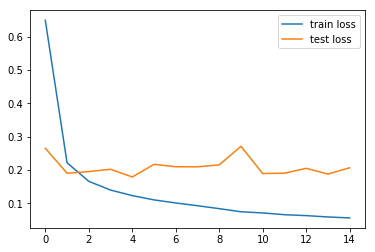

In [31]:
# Plot the train loss and test loss per iteration
_ = plt.plot(train_losses, label='train loss')
_ = plt.plot(test_losses, label='test loss')
_ = plt.legend()
_ = plt.show()

## Test 

In [32]:
def decode_predictions(output, labels, allow_consecutive=False, verbose=False):
    #print('output.shape:', output.shape)
    arg_maxes = torch.argmax(output, dim=2)
    #print('arg_maxes:',arg_maxes)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = ''
        target = ''
        previous_letter = '@'
        if verbose:
            print('i:',i)
            print('args:',args)
            print('labels[i]:',labels[i])
            print('labels[i][:label_lengths[i]]:', labels[i][:int(label_lengths[i])])
        
        for j, index_ in enumerate(labels[i]):
            index = index_.item()
            target_letter = index_map[index+1]
            if verbose:
                print('target_letter:%s' % target_letter)
            if target_letter != ' ' and target_letter !="'":
                target += target_letter
        
        if verbose:
            print('target:',target)
        targets.append(target)
        for j, index_ in enumerate(args):
            index = index_.item()
            predicted_letter = index_map[index+1]
            if verbose:
                print('letter:%s' % predicted_letter)
            if predicted_letter != ' ' and predicted_letter !="'" and predicted_letter != previous_letter:
                decode += predicted_letter
                previous_letter = predicted_letter
        if verbose:
            print("decoded:", decode)
        decodes.append(decode)
    return decodes, targets

In [33]:
from IPython.display import Markdown
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

inputs = torch.from_numpy(X_test[0:NB_TEST_SAMPLES]).float()
labels = torch.from_numpy(Y_test[0:NB_TEST_SAMPLES]).float()
inputs, targets = inputs.to(device), labels.to(device)
predicted = model(inputs)
phonemess, target_phonemess = decode_predictions(predicted, labels)

n_tested = 0
n_ok = 0
n_ko = 0

debug_str = '[MOT] /PRONONCIATION WIKTIONNAIRE/ vs /PRONONCIATION PREDITE/<br>'

targets = []
predictions = []

#NB_TEST_SAMPLES = 10
for i in range(100):
    phonemes = ''
    mot = get_string_from_numpy(mots_test[i])
    prononciation = get_string_from_numpy(prononciations_test[i])
    
    debug_str += '[' + mot + ']' + '/' + prononciation + '/ : '
    
    #prononciation = phonemes_test[i]
    phonemes = phonemess[i]
    target_phonemes = target_phonemess[i]
    debug_str += '/' + target_phonemes + '/ vs '
    
    targets.append(prononciation)
    predictions.append(phonemes)
    debug_str += '/' + phonemes + '/'
    n_tested += 1
    if phonemes == target_phonemes:
        debug_str += ': <span style="color: #00ff00">ok</span><br>'
        n_ok += 1
    else:
        debug_str += ': <span style="color: #ff0000">ko</span><br>'  
        n_ko += 1
display (Markdown(debug_str))
        
print('n_tested:%d, n_ok:%d, n_ko:%d' % (n_tested, n_ok, n_ko))

[MOT] /PRONONCIATION WIKTIONNAIRE/ vs /PRONONCIATION PREDITE/<br>[émarger]/emaʁʒe/ : /emaʁʒe/ vs /emaʁʒe/: <span style="color: #00ff00">ok</span><br>[atchoumer]/atʃume/ : /atʃume/ vs /adʃume/: <span style="color: #ff0000">ko</span><br>[oseri]/ɔzəʁi/ : /ɔzəʁi/ vs /pɑ̃vʁe/: <span style="color: #ff0000">ko</span><br>[admirablement]/admiʁabləmɑ̃/ : /admiʁabləmɑ̃/ vs /adiʁabləmɑ̃/: <span style="color: #ff0000">ko</span><br>[tolstoïser]/tɔlstɔize/ : /tɔlstɔize/ vs /tɔlstɔlize/: <span style="color: #ff0000">ko</span><br>[déboiseuse]/debwazøz/ : /debwazøz/ vs /devwzøz/: <span style="color: #ff0000">ko</span><br>[faro]/faʁo/ : /faʁo/ vs /faʁo/: <span style="color: #00ff00">ok</span><br>[sécheuse]/seʃøz/ : /seʃøz/ vs /sɛʃøz/: <span style="color: #ff0000">ko</span><br>[allitérer]/aliteʁe/ : /aliteʁe/ vs /aliteʁe/: <span style="color: #00ff00">ok</span><br>[drill]/dʁil/ : /dʁil/ vs /dʁej/: <span style="color: #ff0000">ko</span><br>[dessication]/desikasjɔ̃/ : /desikasjɔ̃/ vs /desikasjɔ̃/: <span style="color: #00ff00">ok</span><br>[cent et cent fois]/sɑ̃esɑ̃fwa/ : /sɑ̃esɑ̃fwa/ vs /sɑ̃məsɑ̃fwa/: <span style="color: #ff0000">ko</span><br>[confectionneuse]/kɔ̃fɛksjɔnøz/ : /kɔ̃fɛksjɔnøz/ vs /kɔ̃fɛksjɔnøz/: <span style="color: #00ff00">ok</span><br>[Peintre]/pɛ̃tʁ/ : /pɛ̃tʁ/ vs /pɛtʁ/: <span style="color: #ff0000">ko</span><br>[ophidisme]/ɔfidism/ : /ɔfidism/ vs /ɔfidism/: <span style="color: #00ff00">ok</span><br>[agrédir]/aɡʁediʁ/ : /aɡʁediʁ/ vs /aɡʁediʁ/: <span style="color: #00ff00">ok</span><br>[cibleuse]/sibløz/ : /sibløz/ vs /sibløz/: <span style="color: #00ff00">ok</span><br>[co-indiquas]/koɛ̃dika/ : /koɛ̃dika/ vs /koɛ̃dika/: <span style="color: #00ff00">ok</span><br>[déontologiquement]/deɔ̃toloʒikmɑ̃/ : /deɔ̃toloʒikmɑ̃/ vs /deɑ̃tɔlɔʒikmɑ̃/: <span style="color: #ff0000">ko</span><br>[bimestriellement]/bimɛstʁijɛlmɑ̃/ : /bimɛstʁijɛlmɑ̃/ vs /dimaskʁiɛlmɑ̃/: <span style="color: #ff0000">ko</span><br>[flambeuse]/flɑ̃bøz/ : /flɑ̃bøz/ vs /flɑ̃bøz/: <span style="color: #00ff00">ok</span><br>[trollisme]/tʁɔlism/ : /tʁɔlism/ vs /tʁɔlism/: <span style="color: #00ff00">ok</span><br>[gotha]/ɡɔta/ : /ɡɔta/ vs /ɡɔta/: <span style="color: #00ff00">ok</span><br>[s’avachir]/savaʃiʁ/ : /savaʃiʁ/ vs /saʁaʃiʁ/: <span style="color: #ff0000">ko</span><br>[tomber amoureux]/tɔ̃beamuʁø/ : /tɔ̃beamuʁø/ vs /tɔ̃beamuʁø/: <span style="color: #00ff00">ok</span><br>[pousser la chansonnette]/puselaʃɑ̃sɔnɛt/ : /puselaʃɑ̃sɔnɛt/ vs /puselaʃɑ̃sɔnɛt/: <span style="color: #00ff00">ok</span><br>[abbecquiez]/abɛkje/ : /abɛkje/ vs /abɛke/: <span style="color: #ff0000">ko</span><br>[abandonnât]/abɑ̃dɔna/ : /abɑ̃dɔna/ vs /abɑ̃dɔna/: <span style="color: #00ff00">ok</span><br>[languissamment]/lɑ̃ɡisamɑ̃/ : /lɑ̃ɡisamɑ̃/ vs /lɑ̃ɡisamɑ̃/: <span style="color: #00ff00">ok</span><br>[biunivoquement]/biynivɔkmɑ̃/ : /biynivɔkmɑ̃/ vs /dʒjymydivɔkmɑ̃/: <span style="color: #ff0000">ko</span><br>[clé]/kle/ : /kle/ vs /kle/: <span style="color: #00ff00">ok</span><br>[chimiquement]/ʃimikmɑ̃/ : /ʃimikmɑ̃/ vs /ʃimikmɑ̃/: <span style="color: #00ff00">ok</span><br>[dégustoir]/deɡystwaʁ/ : /deɡystwaʁ/ vs /deɡyʃtwaʁ/: <span style="color: #ff0000">ko</span><br>[biofilm]/bjɔfilm/ : /bjɔfilm/ vs /bjɔfilm/: <span style="color: #00ff00">ok</span><br>[retressauter]/ʁətʁesɔte/ : /ʁətʁesɔte/ vs /ʁətʁɛsɔte/: <span style="color: #ff0000">ko</span><br>[repersister]/ʁəpɛʁsiste/ : /ʁəpɛʁsiste/ vs /ʁəpɛʁze/: <span style="color: #ff0000">ko</span><br>[anti-féministe]/ɑ̃tifeminist/ : /ɑ̃tifeminist/ vs /ɑ̃tifeminist/: <span style="color: #00ff00">ok</span><br>[antidouleur]/ɑ̃tidulœʁ/ : /ɑ̃tidulœʁ/ vs /ɑ̃tidulœʁ/: <span style="color: #00ff00">ok</span><br>[parallactiquement]/paʁalaktikmɑ̃/ : /paʁalaktikmɑ̃/ vs /paʁalaktikmɑ̃/: <span style="color: #00ff00">ok</span><br>[névralgiser]/nevʁalʒize/ : /nevʁalʒize/ vs /nɛvʁalʒize/: <span style="color: #ff0000">ko</span><br>[découvrir la lune]/dekuvʁiʁlalyn/ : /dekuvʁiʁlalyn/ vs /dekuvʁiʁlalyn/: <span style="color: #00ff00">ok</span><br>[mouluration]/mulyʁasjɔ̃/ : /mulyʁasjɔ̃/ vs /mulyʁasjɔ̃/: <span style="color: #00ff00">ok</span><br>[flottoyer]/flɔtwaje/ : /flɔtwaje/ vs /flotwaje/: <span style="color: #ff0000">ko</span><br>[champignonniste]/ʃɑ̃piɲɔnist/ : /ʃɑ̃piɲɔnist/ vs /ʃɑ̃piɲɔnist/: <span style="color: #00ff00">ok</span><br>[courir le guilledou]/kuʁiʁləɡijdu/ : /kuʁiʁləɡijdu/ vs /kuʁiʁləɡidu/: <span style="color: #ff0000">ko</span><br>[se présenter]/səpʁezɑ̃te/ : /səpʁezɑ̃te/ vs /səpʁezɑ̃te/: <span style="color: #00ff00">ok</span><br>[repapillonner]/ʁəpapijɔne/ : /ʁəpapijɔne/ vs /ʁəpapjɔne/: <span style="color: #ff0000">ko</span><br>[ailurophile]/elyʁofil/ : /elyʁofil/ vs /elyʁofil/: <span style="color: #00ff00">ok</span><br>[babichon]/babiʃɔ̃/ : /babiʃɔ̃/ vs /babiʃɔ̃/: <span style="color: #00ff00">ok</span><br>[cynonymie]/sinɔnimi/ : /sinɔnimi/ vs /sinɔnimi/: <span style="color: #00ff00">ok</span><br>[chevreter]/ʃəvʁəte/ : /ʃəvʁəte/ vs /ʃəvʁəte/: <span style="color: #00ff00">ok</span><br>[s’abstraire]/sabstʁɛʁ/ : /sabstʁɛʁ/ vs /sabstʁɛʁ/: <span style="color: #00ff00">ok</span><br>[eh bien]/ebjɛ̃/ : /ebjɛ̃/ vs /ebjɛ̃/: <span style="color: #00ff00">ok</span><br>[mettre en terre]/mɛtʁɑ̃tɛʁ/ : /mɛtʁɑ̃tɛʁ/ vs /mɛtʁɑ̃tɛʁ/: <span style="color: #00ff00">ok</span><br>[hocher]/ɔʃe/ : /ɔʃe/ vs /ɔʃe/: <span style="color: #00ff00">ok</span><br>[autoprotection]/otɔpʁɔtɛksjɔ̃/ : /otɔpʁɔtɛksjɔ̃/ vs /otopʁɔtɛksjɔ̃/: <span style="color: #ff0000">ko</span><br>[tisonneuse]/tizɔnøz/ : /tizɔnøz/ vs /tizɔnøz/: <span style="color: #00ff00">ok</span><br>[grinchir]/ɡʁɛ̃ʃiʁ/ : /ɡʁɛ̃ʃiʁ/ vs /ɡʁɛ̃ʃiʁ/: <span style="color: #00ff00">ok</span><br>[colombaud]/kɔlɔ̃bo/ : /kɔlɔ̃bo/ vs /kɔlɑ̃bo/: <span style="color: #ff0000">ko</span><br>[décapsidation]/dekapsidasjɔ̃/ : /dekapsidasjɔ̃/ vs /dekaksidasjɔ̃/: <span style="color: #ff0000">ko</span><br>[paléontologiste]/paleɔ̃tɔlɔʒist/ : /paleɔ̃tɔlɔʒist/ vs /paleɔ̃tɔlɔʒist/: <span style="color: #00ff00">ok</span><br>[carignan]/kaʁiɲɑ̃/ : /kaʁiɲɑ̃/ vs /kaʁiɲɑ̃/: <span style="color: #00ff00">ok</span><br>[conso]/kɔ̃so/ : /kɔ̃so/ vs /kɔ̃so/: <span style="color: #00ff00">ok</span><br>[atourneuse]/atuʁnøz/ : /atuʁnøz/ vs /atuʁnøz/: <span style="color: #00ff00">ok</span><br>[retroller]/ʁətʁole/ : /ʁətʁole/ vs /ʁətʁɔle/: <span style="color: #ff0000">ko</span><br>[pédomètre]/pedɔmɛtʁ/ : /pedɔmɛtʁ/ vs /pedɔmɛtʁ/: <span style="color: #00ff00">ok</span><br>[s’auto-amortir]/sɔtoamɔʁtiʁ/ : /sɔtoamɔʁtiʁ/ vs /sotoamɔʁtiʁ/: <span style="color: #ff0000">ko</span><br>[remaniérer]/ʁəmanjeʁe/ : /ʁəmanjeʁe/ vs /ʁəmaneʁe/: <span style="color: #ff0000">ko</span><br>[marcher à quatre pattes]/maʁʃeakatʁpat/ : /maʁʃeakatʁpat/ vs /maʁʃeakatʁpat/: <span style="color: #00ff00">ok</span><br>[boycotteuse]/bɔjkɔtøz/ : /bɔjkɔtøz/ vs /bœjkɔtøz/: <span style="color: #ff0000">ko</span><br>[préfacturation]/pʁefaktyʁasjɔ̃/ : /pʁefaktyʁasjɔ̃/ vs /pʁefaktyʁasjɔ̃/: <span style="color: #00ff00">ok</span><br>[carpe diem]/kaʁpedjɛm/ : /kaʁpedjɛm/ vs /kaʁpedjɛm/: <span style="color: #00ff00">ok</span><br>[socinianisme]/sɔsinjanism/ : /sɔsinjanism/ vs /sosiɲjanism/: <span style="color: #ff0000">ko</span><br>[acclamatif]/aklamatif/ : /aklamatif/ vs /aklamatif/: <span style="color: #00ff00">ok</span><br>[aérotransport]/aeʁɔtʁɑ̃spɔʁ/ : /aeʁɔtʁɑ̃spɔʁ/ vs /aeʁotʁɑ̃skɔʁ/: <span style="color: #ff0000">ko</span><br>[course de cheval]/kuʁsdəʃəval/ : /kuʁsdəʃəval/ vs /kuʁsdəʃəʁal/: <span style="color: #ff0000">ko</span><br>[anthropomagnétisme]/ɑ̃tʁɔpɔmaɲetism/ : /ɑ̃tʁɔpɔmaɲetism/ vs /ɑ̃tʁɔpɔmaɲetism/: <span style="color: #00ff00">ok</span><br>[soc]/sɔk/ : /sɔk/ vs /sɔk/: <span style="color: #00ff00">ok</span><br>[transfert d’ADN]/tʁɑ̃sfɛʁdadeɛn/ : /tʁɑ̃sfɛʁdadeɛn/ vs /tʁɑ̃sfɛʁdədeɛn/: <span style="color: #ff0000">ko</span><br>[blasonneur]/blazɔnœʁ/ : /blazɔnœʁ/ vs /blazɔnœʁ/: <span style="color: #00ff00">ok</span><br>[être mindé]/ɛtʁmajnde/ : /ɛtʁmajnde/ vs /ɛtʁmɛ̃de/: <span style="color: #ff0000">ko</span><br>[niveler]/nivəle/ : /nivəle/ vs /nivle/: <span style="color: #ff0000">ko</span><br>[adhésiver]/adezive/ : /adezive/ vs /adezive/: <span style="color: #00ff00">ok</span><br>[tarification]/taʁifikasjɔ̃/ : /taʁifikasjɔ̃/ vs /taʁifikasjɔ̃/: <span style="color: #00ff00">ok</span><br>[popper]/pɔpe/ : /pɔpe/ vs /pɔpe/: <span style="color: #00ff00">ok</span><br>[par Toutatis]/paʁtutatis/ : /paʁtutatis/ vs /paʁtutatis/: <span style="color: #00ff00">ok</span><br>[clavardesque]/klavaʁdɛsk/ : /klavaʁdɛsk/ vs /klavaʁdɛsk/: <span style="color: #00ff00">ok</span><br>[pyrothécophile]/piʁɔtekɔfil/ : /piʁɔtekɔfil/ vs /piʁotekɔfil/: <span style="color: #ff0000">ko</span><br>[salivation]/salivasjɔ̃/ : /salivasjɔ̃/ vs /salivasjɔ̃/: <span style="color: #00ff00">ok</span><br>[fressure]/fʁɛsyʁ/ : /fʁɛsyʁ/ vs /fʁɛsyʁ/: <span style="color: #00ff00">ok</span><br>[faire la couverture]/fɛʁlakuvɛʁtyʁ/ : /fɛʁlakuvɛʁtyʁ/ vs /fɛʁlakuvɛʁtyʁ/: <span style="color: #00ff00">ok</span><br>[sécuritarisme]/sekyʁitaʁism/ : /sekyʁitaʁism/ vs /sikyʁitaʁism/: <span style="color: #ff0000">ko</span><br>[lilas]/lila/ : /lila/ vs /ila/: <span style="color: #ff0000">ko</span><br>[nucal]/nykal/ : /nykal/ vs /nykal/: <span style="color: #00ff00">ok</span><br>[dogmatiser]/dɔɡmatize/ : /dɔɡmatize/ vs /dɔɡmatize/: <span style="color: #00ff00">ok</span><br>[boustifailleuse]/bustifajøz/ : /bustifajøz/ vs /bustifajøz/: <span style="color: #00ff00">ok</span><br>[triskaïdékaphobie]/tʁiskajdekafɔbi/ : /tʁiskajdekafɔbi/ vs /tʁiskaʁidekafɔbi/: <span style="color: #ff0000">ko</span><br>[repâlir]/ʁəpɑliʁ/ : /ʁəpɑliʁ/ vs /ʁəpaliʁ/: <span style="color: #ff0000">ko</span><br>[déraisonner]/deʁɛzɔne/ : /deʁɛzɔne/ vs /deʁezɔne/: <span style="color: #ff0000">ko</span><br>[rousseler]/ʁusəle/ : /ʁusəle/ vs /ʁosəle/: <span style="color: #ff0000">ko</span><br>

n_tested:100, n_ok:59, n_ko:41


In [34]:
TEST_SAMPLESS = 3
unit_inputs = torch.from_numpy(X_test[0:TEST_SAMPLESS]).float()
unit_labels = torch.from_numpy(Y_test[0:TEST_SAMPLESS]).float()
unit_inputs, unit_targets = unit_inputs.to(device), unit_labels.to(device)
unit_predicted = model(unit_inputs)
decode_predictions(unit_predicted, unit_labels, verbose=False)

(['emaʁʒe', 'atʃume', 'ɔzʁe'], ['emaʁʒe', 'atʃume', 'ɔzəʁi'])

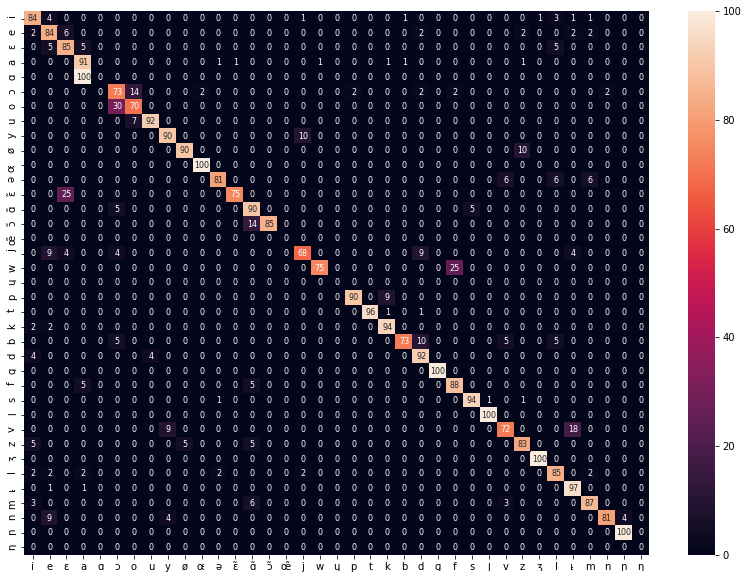

In [35]:
# create a copy of char_map without \' and <SPACE>
char_map2 = char_map.copy()
del char_map2["'"]
del char_map2["<SPACE>"]

counting_bad_cases = Counter({})
n_bad_letters = 0

# fill a confusion matrix 
confusion_array = np.zeros((len(char_map),len(char_map)))
for i in range(len(targets)):
    target_phonemes = get_phonemes(targets[i])
    prediction_phonemes = get_phonemes(predictions[i])
    for j in range(len(target_phonemes)):
        letter_targeted = target_phonemes[j]
        if j < len(prediction_phonemes):
            letter_predicted = prediction_phonemes[j]
            letter_targeted_index = char_map[letter_targeted]
            letter_predicted_index = char_map[letter_predicted]
            try:
                confusion_array[letter_targeted_index, letter_predicted_index] += 1
            except:
                print('error target letter:%s (%s), prediction:%s, predicted letter (in %s)' %\
                (letter_targeted, targets[i], letter_predicted, predictions[i]))
            if letter_predicted != letter_targeted : 
                key = letter_predicted + '-' + letter_targeted
                counting_bad_cases[key] += 1
                n_bad_letters += 1

for t in range(confusion_array.shape[0]):
    sum = 0
    for p in range(confusion_array.shape[1]):
        sum += confusion_array[t, p]
    for p in range(confusion_array.shape[1]):
        if sum > 0:
            confusion_array[t, p] = int(confusion_array[t, p]/sum*100)
            
# display the confusion matrix
# create a copy of char map without first two chars (' and SPACE)
char_map2 = char_map.copy()
del char_map2["'"]
del char_map2["<SPACE>"]
# display the confusion matrix without first 2 rows and first 2 colums
df_cm = pd.DataFrame(confusion_array[2:,2:], index = [i for i in char_map2],
                  columns = [i for i in char_map2])
_ = plt.figure(figsize = (14,10))
_ = sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='g')
_ = plt.show()

In [36]:
n_bad_letters

101

In [37]:
for key in counting_bad_cases.keys():
    counting_bad_cases[key] = int(counting_bad_cases[key]/n_bad_letters*10000)/100

print("percentage of the different errors:")
print("(predicted_phoneme-target_phoneme), percentage")
counting_bad_cases.most_common()

percentage of the different errors:
(predicted_phoneme-target_phoneme), percentage


[('o-ɔ', 5.94),
 ('e-i', 2.97),
 ('ɛ-e', 2.97),
 ('ɔ-o', 2.97),
 ('ɑ̃-m', 1.98),
 ('l-i', 1.98),
 ('ɑ̃-ɔ̃', 1.98),
 ('d-b', 1.98),
 ('ʁ-v', 1.98),
 ('e-j', 1.98),
 ('d-j', 1.98),
 ('e-n', 1.98),
 ('k-p', 1.98),
 ('d-t', 0.99),
 ('p-ɔ', 0.99),
 ('ɑ̃-z', 0.99),
 ('v-ə', 0.99),
 ('i-m', 0.99),
 ('ʁ-i', 0.99),
 ('a-ʁ', 0.99),
 ('b-a', 0.99),
 ('l-b', 0.99),
 ('ə-l', 0.99),
 ('m-ə', 0.99),
 ('i-z', 0.99),
 ('z-e', 0.99),
 ('v-b', 0.99),
 ('z-a', 0.99),
 ('ø-z', 0.99),
 ('z-ø', 0.99),
 ('j-l', 0.99),
 ('m-e', 0.99),
 ('ə-s', 0.99),
 ('s-ɑ̃', 0.99),
 ('ɑ̃-f', 0.99),
 ('f-w', 0.99),
 ('w-a', 0.99),
 ('ɛ-ɛ̃', 0.99),
 ('a-ɛ', 0.99),
 ('k-t', 0.99),
 ('ɛ-j', 0.99),
 ('l-ɛ', 0.99),
 ('m-l', 0.99),
 ('ʒ-i', 0.99),
 ('j-y', 0.99),
 ('y-n', 0.99),
 ('m-i', 0.99),
 ('y-v', 0.99),
 ('d-ɔ', 0.99),
 ('i-k', 0.99),
 ('v-m', 0.99),
 ('ɔ-ɑ̃', 0.99),
 ('ʃ-s', 0.99),
 ('z-s', 0.99),
 ('u-d', 0.99),
 ('j-i', 0.99),
 ('ɔ-j', 0.99),
 ('n-ɔ', 0.99),
 ('ʁ-e', 0.99),
 ('e-ʁ', 0.99),
 ('œ-ɔ', 0.99),
 ('ɲ-n', 0.99),
